In [7]:
import sys
oldsysstdout = sys.stdout

from matplotlib import pyplot as plt
%matplotlib inline
from anuga.file import netcdf
import matplotlib.tri as tri
import scipy.interpolate as sp
from glob import glob
import numpy as np

sys.stdout = oldsysstdout
from scipy.signal import savgol_filter as filter



swwFile = 'plane2.sww'




fid = netcdf.NetCDFFile(swwFile)
x = fid.variables['x'][:]
y = fid.variables['y'][:]
elev = fid.variables['elevation'][:]
stage = fid.variables['stage'][:]
conc = fid.variables['concentration'][:]

depth = stage - elev

xmom = fid.variables['xmomentum'][:]
xvel = xmom / (depth + 0.000001)

fid.close()



indices = np.where(y == 1.)
        
triang = tri.Triangulation(x,y)

        
# variables        
g = 9.8
rho_w = 1000.
tau_c = 0.126126
phi = 0.3
vs = 0.0138099680617
Co = 0.0046       
Ke = 0.2e-6/(tau_c**0.5)

# d_star
filenames = glob('plane1/dstar*')

ds = np.load(filenames[0])
xx = np.linspace(0.05,14,45)

numbers = []
for f in filenames[1:]:
    a = f.replace('plane1/dstar','')
    b = a.replace('.0.npy','')
    numbers.append(int(b))
    
d_star = np.zeros((len(numbers),len(xx)))


fl = sp.interp1d(x, elev[0], kind='linear')
Dxo = filter(fl(xx), 7, 3)

for i in range(1,len(filenames)):

    ds = np.load(filenames[i])
    fl = sp.interp1d(ds[0], ds[1], kind='linear')
    d_star[i-1] = filter(fl(xx), 7, 3)
    

Cx = np.zeros((len(numbers),len(xx)))
Dx = np.zeros((len(numbers),len(xx)))

S = -np.diff(Dxo)/np.diff(xx)
slope = np.hstack((S,S[-1]))

for i in numbers:
    
    j = i/5 - 1

    d_star_u = d_star[j]

    
    fl = sp.interp1d(x, depth[-1], kind='linear')
    dxx = filter(fl(xx), 5, 3)
    
#     fl = sp.interp1d(x, xvel[-1], kind='linear')
#     vxx = filter(fl(xx), 15, 3)
    
#     qxx = dxx * vxx

    fl = sp.interp1d(x, xmom[-1], kind='linear')
    qxx = filter(fl(xx), 7, 3)
    
    fl = sp.interp1d(x, elev[i], kind='linear')
    Dxd = filter(fl(xx), 7, 3)
    S = -np.diff(Dxd)/np.diff(xx)
    slope = np.hstack((S,S[-1]))
    

    u_star = np.sqrt(g * slope * dxx)
    tau = rho_w * u_star**2
    dot_E = Ke * (tau - tau_c)

#     fl = sp.interp1d(x, dot_E, kind='linear')
#     Exx = fl(xx)
    Exx = dot_E

    Cx[j] = (Co - Exx/(d_star_u * vs)) * np.exp(- d_star_u * vs * xx / qxx) + Exx/(d_star_u * vs)    
    Dx[j] = i / (1 - phi) * (d_star_u * vs * Co - Exx) * np.exp(- d_star_u * vs * xx / qxx) + Dxo
    
    S = -np.diff(Dx[j])/np.diff(xx)
    slope = np.hstack((S,S[-1]))


print 'done'



# check data

Cx_m = np.zeros((len(numbers),len(xx)))
Dx_m = np.zeros((len(numbers),len(xx)))

for i in numbers:
    
    j = i/5 - 1
    
    fl = sp.interp1d(x, elev[i], kind='linear')
    Dx_m[j] = filter(fl(xx), 7, 3)
    
    fl = sp.interp1d(x, conc[i], kind='linear')
    Cx_m[j] = filter(fl(xx), 7, 3)
    

done


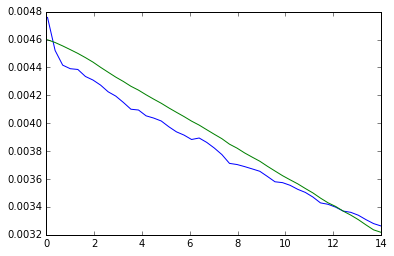

In [8]:
plt.plot(xx, Cx_m[-1],xx, Cx[-1])